In [30]:
import pandas as pd
import json 
from collections import *
from glob import glob
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from numpy import reshape
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support
from os.path import basename

from sklearn.cluster import KMeans

from sklearn.dummy import DummyClassifier

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [7]:
ablation_dir = '/shared/2/projects/contextual-appropriateness/models/peft/ablation/'

In [23]:
dfs = []
for fname in glob(ablation_dir + '*.csv'):
    df = pd.read_csv(fname)
    
    cat = basename(fname).split('.')[1].replace("Perr", "Peer")
    df['ablated_cat'] = cat
    dfs.append(df)
    
df = pd.concat(dfs)
df.replace({'Perr group': 'Peer group'}, inplace=True)
df.head()

,id,relationship,is_appropriate,label,quote,origin,category,text,answer,predicted,ablated_cat
0,773,ex_dating,Yes,0,He needs to get high school diploma too,Adjudication,Romance,Rate whether it is inappropriate for this mess...,no,0,Organizational
1,773,colleague,Yes,0,He needs to get high school diploma too,Adjudication,Organizational,Rate whether it is inappropriate for this mess...,no,0,Organizational
2,773,engaged,Yes,0,He needs to get high school diploma too,Adjudication,Romance,Rate whether it is inappropriate for this mess...,no,0,Organizational
3,773,best_friend,Yes,0,He needs to get high school diploma too,Adjudication,Social,Rate whether it is inappropriate for this mess...,no,0,Organizational
4,773,neighbor,Yes,0,He needs to get high school diploma too,Adjudication,Social,Rate whether it is inappropriate for this mess...,no,0,Organizational


In [17]:
df.head()

,id,relationship,is_appropriate,label,quote,origin,category,text,answer,predicted,ablated_cat
0,773,ex_dating,Yes,0,He needs to get high school diploma too,Adjudication,Romance,Rate whether it is inappropriate for this mess...,no,0,Organizational
1,773,colleague,Yes,0,He needs to get high school diploma too,Adjudication,Organizational,Rate whether it is inappropriate for this mess...,no,0,Organizational
2,773,engaged,Yes,0,He needs to get high school diploma too,Adjudication,Romance,Rate whether it is inappropriate for this mess...,no,0,Organizational
3,773,best_friend,Yes,0,He needs to get high school diploma too,Adjudication,Social,Rate whether it is inappropriate for this mess...,no,0,Organizational
4,773,neighbor,Yes,0,He needs to get high school diploma too,Adjudication,Social,Rate whether it is inappropriate for this mess...,no,0,Organizational


In [35]:
cat_to_rels = defaultdict(set)
for row in df.itertuples():
    cat_to_rels[row.category].add(row.relationship)

In [20]:
ablated_cats = set(df.ablated_cat)
Counter(df.ablated_cat)

Counter({'Organizational': 2029,
         'Role Based': 2029,
         'Antagonist': 2029,
         'Parasocial': 2029,
         'Romance': 2029,
         'Family': 2029,
         'Social': 2029,
         'Peer group': 2029})

In [24]:
Counter(df.category)

Counter({'Romance': 3448,
         'Organizational': 2664,
         'Social': 3496,
         'Family': 3888,
         'Role Based': 1688,
         'Peer group': 720,
         'Antagonist': 240,
         'Parasocial': 88})

In [36]:
is_ablated_col = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    ablated_cat = row['ablated_cat']
    rel = row['relationship']
    is_rel_ablated = rel in cat_to_rels[ablated_cat] 
    is_ablated_col.append(is_rel_ablated)

df['is_rel_ablated'] = is_ablated_col

  0%|          | 0/16232 [00:00<?, ?it/s]

In [37]:
Counter(df.is_rel_ablated)

Counter({False: 14203, True: 2029})

In [156]:
renames = {
 'enemy': "Antagonist",
 'family': "Family",
 'fan': "Parasocial",
 'friend': "Social",
 'romance': "Romance",
 'socialRoles': "Role-based",
 'teammates': "Peer-group",
 'work': "Organizational"    
}

In [38]:
f1_df = defaultdict(list)

for cat in tqdm(ablated_cats):
    sub_df = df[df.ablated_cat == cat]
        
    non_ablated = sub_df[~sub_df.is_rel_ablated]
    for _ in range(1000):
        s = non_ablated.sample(frac=1, replace=True)
        f1 = f1_score(s.label, s.predicted, average='binary')
        f1_df['Ablated'].append(cat)
        f1_df['F1'].append(f1)
        f1_df['Relationship Type'].append('Relationships Seen in Training')
        
    ablated = sub_df[sub_df.is_rel_ablated]    
    for _ in range(1000):
        s = ablated.sample(frac=1, replace=True)
        f1 = f1_score(s.label, s.predicted, average='binary')
        f1_df['Ablated'].append(cat)
        f1_df['F1'].append(f1)
        f1_df['Relationship Type'].append('Held-out Relationships')
    

    # TODO: Figure out how to report random performance
    #random_dummy_clf = DummyClassifier(strategy="stratified")
    #random_dummy_clf.fit(non_ablated.quote, non_ablated.actual)
    #random_dummy_dev_preds = random_dummy_clf.predict(dev_df.text)
    #f1_df['Ablated'].append(cat)
    #f1_df['F1'].append(f1)
    #f1_df['Relationship Type'].append('Held-out Relationships')
    
    
f1_df = pd.DataFrame(f1_df)
f1_df.head()

  0%|          | 0/8 [00:00<?, ?it/s]

,Ablated,F1,Relationship Type
0,Parasocial,0.692768,Relationships Seen in Training
1,Parasocial,0.697569,Relationships Seen in Training
2,Parasocial,0.672875,Relationships Seen in Training
3,Parasocial,0.701284,Relationships Seen in Training
4,Parasocial,0.680065,Relationships Seen in Training


In [44]:
sdf = f1_df[f1_df['Relationship Type'] == 'Relationships Seen in Training']
f1_df_gb = sdf.groupby(['Ablated']).mean('F1').reset_index().sort_values('F1', ascending=False)
order = f1_df_gb.Ablated
f1_df_gb

,Ablated,F1
6,Romance,0.719397
1,Family,0.712955
4,Peer group,0.700159
3,Parasocial,0.696756
7,Social,0.696444
0,Antagonist,0.680116
5,Role Based,0.669115
2,Organizational,0.646673


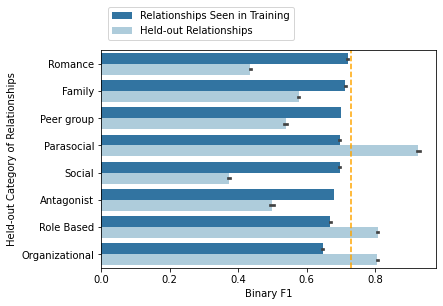

In [46]:

palette = sns.color_palette("Paired", n_colors=2)#  sns.color_palette("Blues_d", n_colors=n_plots)
palette.reverse()

ax = sns.barplot(data=f1_df, x='F1', y='Ablated', hue='Relationship Type', 
                 order=order, hue_order=['Relationships Seen in Training', 'Held-out Relationships'],
                 palette=palette)
plt.axvline(0.73, 0, color='orange', linestyle='--')
plt.legend(bbox_to_anchor=(.02, 1.2), loc='upper left', borderaxespad=0)
ax.set(xlabel='Binary F1', ylabel='Held-out Category of Relationships')
plt.savefig('../../plots/ablation-study.flan-t5-xl.pdf', bbox_inches = "tight")

In [41]:
f1_df[f1_df['Ablated'] == 'Role-based']

,Ablated,F1,Relationship Type


In [45]:
f1_df.groupby(['Ablated', 'Relationship Type']).mean('F1').reset_index().sort_values('F1', ascending=False)


,Ablated,Relationship Type,F1
6,Parasocial,Held-out Relationships,0.926032
10,Role Based,Held-out Relationships,0.808330
4,Organizational,Held-out Relationships,0.806323
13,Romance,Relationships Seen in Training,0.719397
3,Family,Relationships Seen in Training,0.712955
9,Peer group,Relationships Seen in Training,0.700159
7,Parasocial,Relationships Seen in Training,0.696756
15,Social,Relationships Seen in Training,0.696444
1,Antagonist,Relationships Seen in Training,0.680116
11,Role Based,Relationships Seen in Training,0.669115
